In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [3]:
content_path='pair/05057d04f7_real_A.png'
style_path = 'pair/05057d04f7_real_B.png'

In [4]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                               #batch of single image 
    
    return im_array

In [5]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [6]:
content = load_file(content_path)
style = load_file(style_path)

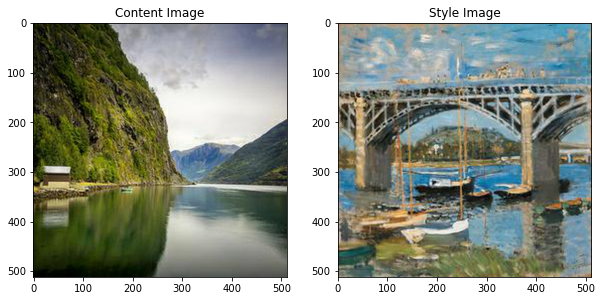

In [7]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

**Define function to process image for input to vgg19 model**

In [8]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [9]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [10]:
im=img_preprocess(content_path)

In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get vgg19 model with pretrained weights**

In [12]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [13]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

2022-05-03 20:41:04.222773: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-03 20:41:04.223023: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 20:41:04.228787: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Model architecture**

In [14]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Define content loss**

In [15]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

**Define style loss**

In [16]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [17]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    

In [18]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

**Define function to compute total loss**

In [19]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

**Define function to calculate gradient**

In [20]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [21]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [22]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [23]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

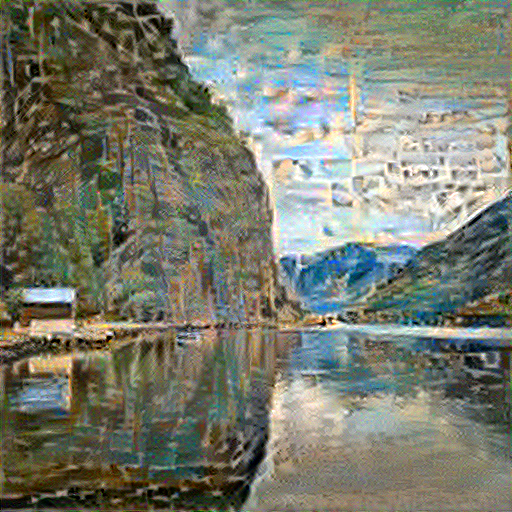

Epoch: 495
Total loss: 2.8904e+05, style loss: 1.0698e+05, content loss: 1.8206e+05, 


In [24]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)


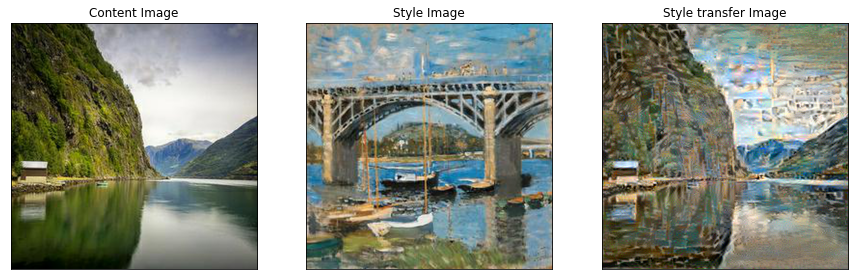

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

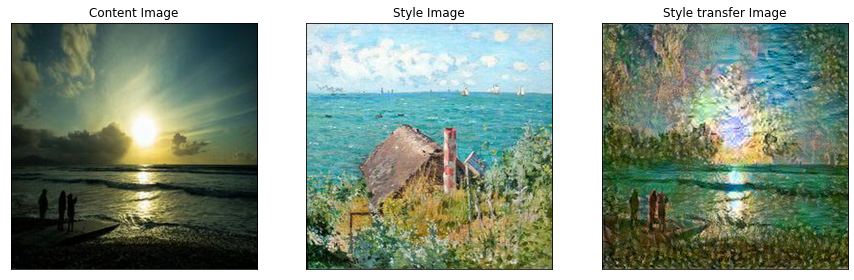

In [36]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

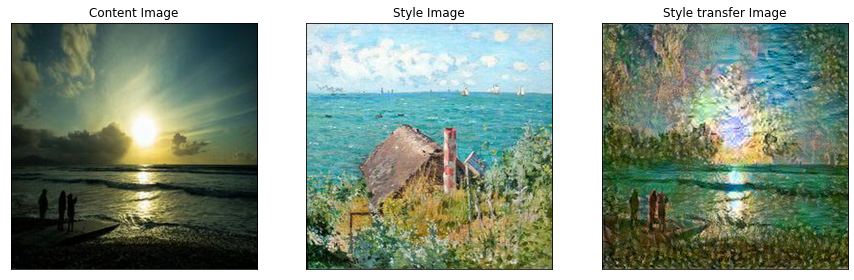

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()


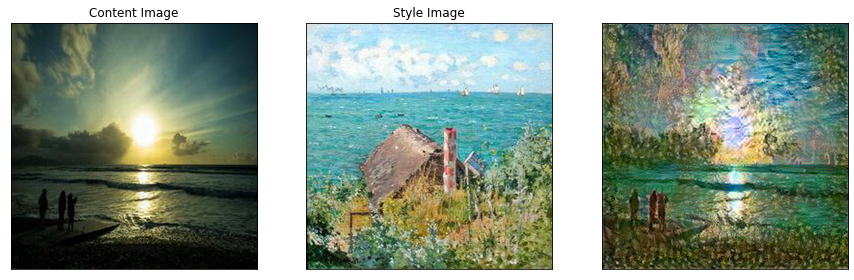

In [39]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()